In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
from collections import OrderedDict
from simulator import get_simulator
from simulate import simulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
system = {
    'duration': 499.0, 
    'resolution': 1.0,
    'species': [
        ('i', 0),
        ('I', 0),
        ('a', 0), 
        ('A', 0),
        ('C', 0),
        ('CC', 0),
        ('t', 0), 
        ('T', 0), 
        ('TT', 0),
    ],
    'reactions': [
        ('sigma_i', (), ((1, 'i'), )), 
        ('alpha_i', ((1, 'i'), ), ((1, 'i'), (1, 'I'))), 
        ('F_i', ((1, 'i'), ), ()), 
        ('Gamma', ((1, 'i'), ), ()), 
        ('G_I', ((1, 'I'), ), ()), 
        ('Gamma', ((1, 'I'), ), ()), 

        ('lambda_ta', (), ((1, 't'), (1, 'a'))), 
        ('alpha_a', ((1, 'a'), ), ((1, 'a'), (1, 'A'))), 
        ('alpha_t', ((1, 't'), ), ((1, 't'), (1, 'T'))), 
        ('F_a', ((1, 'a'), ), ()), 
        ('F_t', ((1, 't'), ), ()), 
        ('Gamma', ((1, 'a'), ), ()), 
        ('Gamma', ((1, 't'), ), ()), 
        ('G_A', ((1, 'A'), ), ()), 
        ('G_T', ((1, 'T'), ), ()), 
        ('G_T', ((1, 'TT'), ), ((1, 'T'), )), 
        ('Gamma', ((1, 'A'), ), ()), 
        ('Gamma', ((1, 'T'), ), ()), 

        ('k_C', ((2, 'T'), ), ((1, 'TT'), )), 
        ('k_C', ((1, 'TT'), (1, 'A')), ((1, 'C'), )), 
        ('k_C', ((2, 'C'), ), ((1, 'CC'), )), 
        ('G_C', ((1, 'C'), ), ((1, 'TT'), )), 
        ('G_C', ((1, 'CC'), ), ((1, 'TT'), (1, 'C'))), 
        ('Gamma', ((1, 'TT'), ), ()), 
        ('Gamma', ((1, 'C'), ), ()), 
        ('Gamma', ((1, 'CC'), ), ()), 
        
    ], 
    'variables': [
        ('sigma_i', 20.0), 
        ('alpha_i', 200.0), 
        ('F_i', 5.0), 
        ('sigma', 20.0), 
        ('k_0', 0.05), 
        ('alpha_t', 200.0), 
        ('nu', 1.6), 
        ('k_C', 1000.0), 
        ('mu_ta', 5.0), 
        ('f_T', 20.0), # change to beta_T
        ('omega', 0.2), 
        ('mu', 100.0), 
        ('epsilon', 0.01), 
        ('kappa', 1.0),
        ('kappa_I', 1.0), 
        ('kappa_A', 1.0), 
        ('kappa_C', 0.1), 
        ('kappa_T', 0.0), 
        ('gamma', 1.0), 
        ('phi', 1.0), 
        ('b_c', 0.25), # change to beta_g
    ], 
    'functions': [
        ('alpha_a', 'alpha_t * nu'), 
        ('T_free', 'T + TT'), 
        ('lambda_ta', 'sigma / (1 + k_0 * (A + C + CC))'), 
        ('F_t', 'mu_ta + f_T * (T + TT)'), # change to beta_t 
        ('F_a', 'mu_ta + f_T * (T + TT) * omega'), # change to beta_a
        ('G', '(kappa * mu) / (epsilon + kappa * (kappa_I * I + kappa_A * A + kappa_C * (C + CC) + kappa_T * (T + TT)))'), # change to zeta 
        ('G_I', 'kappa_I * G'),
        ('G_A', 'kappa_A * G'),
        ('G_C', 'kappa_C * G'),
        ('G_T', 'kappa_T * G'),
        ('Gamma', '(gamma * phi) / (1.0 + b_c * phi * (T + TT))'),
    ], 
    'targets': [
        'time', 
        'I',
        'A',
        'C',
        'CC',
        'T', 
        'TT',
        'T_free',
    ],
}

In [72]:
run = get_simulator(system)

incrementing extension version...
ext module version: gillespie_55 54
Compiling ./gillespie_55.pyx because it changed.
[1/1] Cythonizing ./gillespie_55.pyx
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_55' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/cogle/dev/budget/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/cogle/dev/budget/anaconda3/include/python3.6m -c ./gillespie_55.c -o build/temp.linux-x86_64-3.6/./gillespie_55.o
gcc -pthread -shared -L/home/cogle/dev/budget/anaconda3/lib -Wl,-rpath=/home/cogle/dev/budget/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/./gillespie_55.o -L/home/cogle/dev/budget/anaconda3/lib -lpython3.6m -o /home/cogle/dev/gillespie_modular/.simulators/gillespie_55.cpython-36m-x86_64-linux-gnu.so


In [73]:
data = run(0, sigma_i=0)

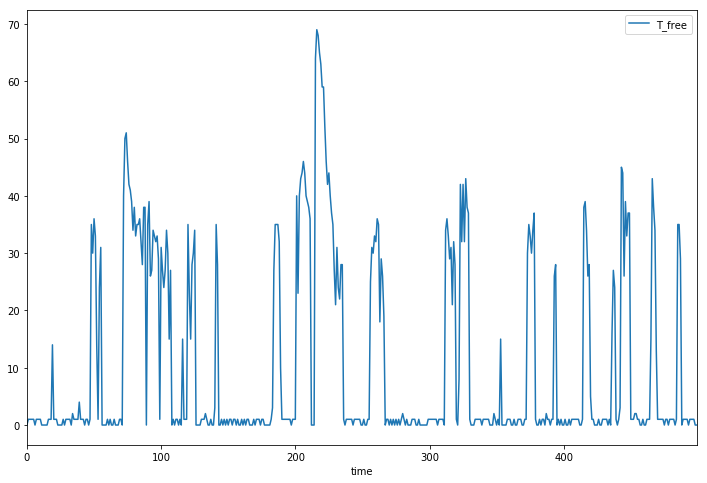

In [74]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], data)))
df.plot(x='time', y=['T_free'], kind='line', figsize=(12, 8))